Nlp tasks


1. Understanding dataset


2. Cleaning (lowercase, remove digits)


3. Removing stopwords


4. Lemmatization


5. Tokenization

6. Padding Text

In [133]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import SpatialDropout1D


In [116]:
data= pd.read_csv('amazon_alexa.tsv',sep='\t')  # tsv is file is tab separated while csv , separated

def sentiments(df):
    if df['rating']>3.0:
        return 'Positive'
    elif df['rating'] <=3.0:
        return 'Negative'

data['sentiment'] = data.apply(sentiments, axis=1)

In [117]:
data.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [118]:
#Check if there any null values in dataset
data_v1= data[['verified_reviews', 'sentiment']]
data_v1.isnull().sum()

verified_reviews    1
sentiment           0
dtype: int64

In [119]:
rows_with_null = data_v1[data_v1.isnull().any(axis=1)]

print(rows_with_null)


    verified_reviews sentiment
473              NaN  Negative


In [121]:
data_v1.isnull().sum()

verified_reviews    1
sentiment           0
dtype: int64

In [122]:
data_v1=data_v1.fillna('love it')

In [123]:
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [124]:
import nltk
nltk.download('stopwords')


[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [125]:
from nltk.corpus import stopwords
def cleaning(df, stop_words):
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:
          ' '.join(x.lower() for x in x.split()))
    
    #replacing digits/numbers
    df['verified_reviews'] = df['verified_reviews'].str.replace('d', '')
    
    #Removing stop words
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x : ''
           .join(x for x in x.split() if x not in stop_words))
    
    #Lemmatization
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 
        ' '.join([Word(x).lemmatize() for x in x.split()]))
    
    return df


stop_words = stopwords.words('english')
data_v1 = cleaning(data_v1, stop_words)

In [94]:
data_v1

,verified_reviews,sentiment
0,loveecho!,Positive
1,loveit!,Positive
2,"sometimesplayinggame,answerquestioncorrectlyal...",Positive
3,"halotfunthing.4yrollearnsinosaurs,controllight...",Positive
4,music,Positive
...,...,...
3145,"perfectkis,aultseveryonebetween!!",Positive
3146,"listeningmusic,searchinglocations,checkingtime...",Positive
3147,"lovethings,runningentirehome,tv,lights,thermos...",Positive
3148,complaintsounqualitygreat.mostlyusecommansthou...,Positive


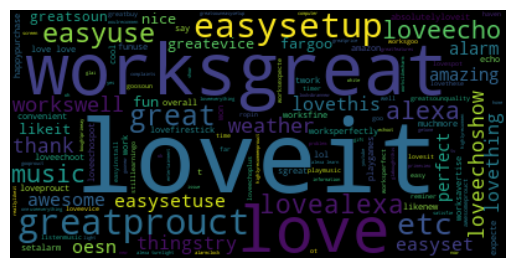

In [126]:
common_words=''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud= wordcloud. WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show()

In [127]:
# Encoded the target column
lb = LabelEncoder()
data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])

In [128]:

data_v1.head()

,verified_reviews,sentiment
0,loveecho!,1
1,loveit!,1
2,"sometimesplayinggame,answerquestioncorrectlyal...",1
3,"halotfunthing.4yrollearnsinosaurs,controllight...",1
4,music,1


In [129]:
data_v1['verified_reviews'] = data_v1['verified_reviews'].astype(str)
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data_v1['verified_reviews'].values)
X = pad_sequences(X)
X

array([[  0,   0,   0, ...,   0,   0,  12],
       [  0,   0,   0, ...,   0,   0,   2],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 218,  97, 165],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,  44]], dtype=int32)

In [140]:
model = Sequential()
model.add(Embedding(500,120, input_length= X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 29, 120)           60000     
                                                                 
 spatial_dropout1d_5 (Spati  (None, 29, 120)           0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269442 (1.03 MB)
Trainable params: 269442 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [142]:
#Splitting data into training and testing 
y = pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.3, random_state=42)


In [143]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [144]:
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size= batch_size, verbose=1)


Epoch 1/5
69/69 [==============================] - 14s 120ms/step - loss: 0.3992 - accuracy: 0.8680
Epoch 2/5
69/69 [==============================] - 8s 112ms/step - loss: 0.3706 - accuracy: 0.8757
Epoch 3/5
69/69 [==============================] - 7s 102ms/step - loss: 0.3361 - accuracy: 0.8785
Epoch 4/5
69/69 [==============================] - 7s 104ms/step - loss: 0.3100 - accuracy: 0.8844
Epoch 5/5
69/69 [==============================] - 6s 87ms/step - loss: 0.3018 - accuracy: 0.8884


In [145]:
model.evaluate(X_test, y_test)


30/30 [==============================] - 1s 16ms/step - loss: 0.3482 - accuracy: 0.8646


[0.34823235869407654, 0.8645502924919128]